In [2]:
%load_ext autoreload
%autoreload 2
%pwd

'/home/luca/uni/master/dl-in-vc/voxl3r'

In [3]:
# setup PYTHONPATH
import sys
sys.path += ['.', './extern/scannetpp', './extern/mast3r', './extern/mast3r/dust3r']

In [4]:
import os
from pathlib import Path
import torch


ckpt_folder = list(Path("./.lightning/mast3r-3d/mast3r-3d/").glob("*"))
ckpt_folder = sorted(ckpt_folder, key=os.path.getmtime)
last_ckpt_folder = ckpt_folder[-1]
last_ckpt = torch.load(last_ckpt_folder / "checkpoints/last.ckpt")

amdgpu.ids: No such file or directory


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Warning, cannot find cuda-compiled version of RoPE2D, using a slow pytorch version instead


In [5]:
data_config = last_ckpt['datamodule_hyper_parameters']['data_config']

In [6]:
from experiments.mast3r_3d.data import Mast3r3DDataModule


data_config
datamodule = Mast3r3DDataModule(data_config=data_config)
datamodule_no_transform = Mast3r3DDataModule(data_config=data_config, no_transform=True)

datamodule.prepare_data()
datamodule.setup("fit")
datamodule.setup("test")

datamodule_no_transform.prepare_data()
datamodule_no_transform.setup("fit")
datamodule_no_transform.setup("test")
train_instance = datamodule.train_dataset[0]
train_instance_no_transform = datamodule_no_transform.train_dataset[0]

20it [00:00, 70.06it/s]                        
20it [00:00, 68.61it/s]                        


In [7]:
data_dict = train_instance_no_transform
res_dict = {**data_dict["pairwise_predictions"][0], **data_dict["pairwise_predictions"][1]}

image_dict = {
            Path(key).name: value
            for key, value in zip(data_dict["images"][0], data_dict["images"][1])
        }

images = torch.stack([
            res_dict[f"desc_{image}"] for image in image_dict.keys()
        ])
images.shape

torch.Size([4, 336, 512, 24])

In [8]:
data_dict["scene_name"]

'54b6127146'

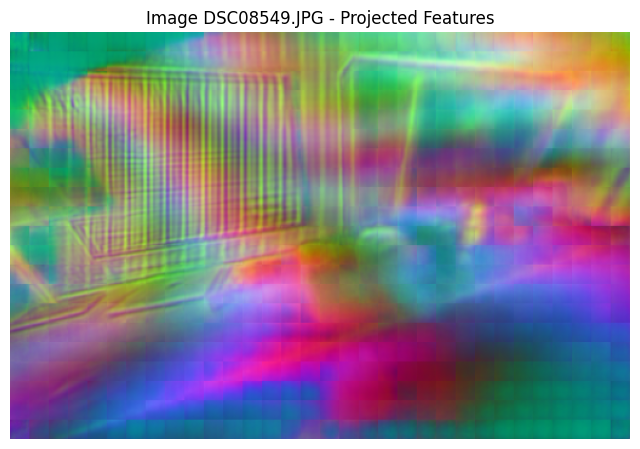

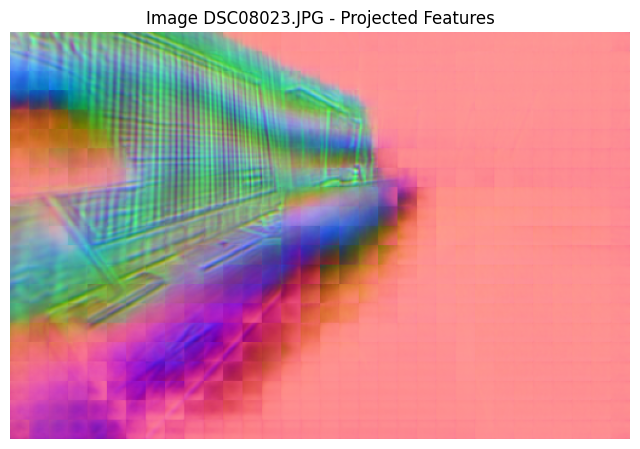

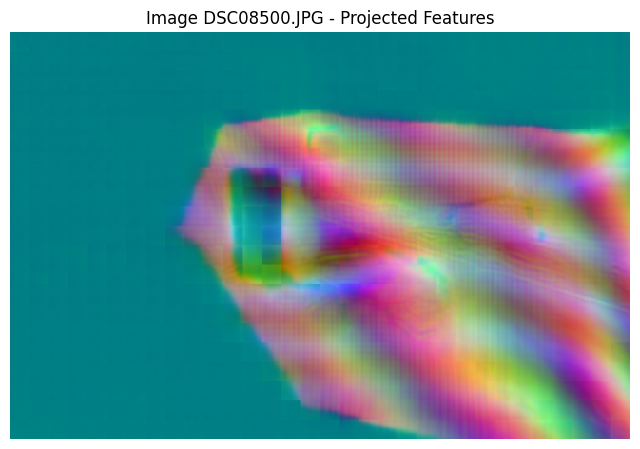

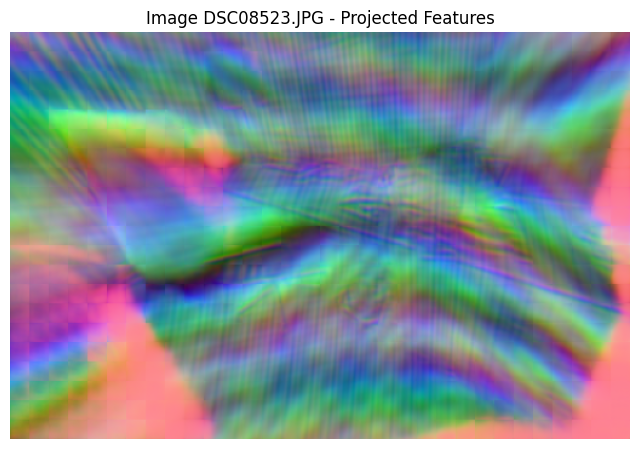

In [9]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assume 'features' is your tensor of shape [num_images, height, width, feature_dim]
# Replace this with your actual data
# For example, using random data:
features = images  # Example data

num_images, height, width, feature_dim = features.shape

# Initialize a list to store the projected features for each image
projected_features = []

for i in range(num_images):
    # Get the feature map for the ith image
    image_features = features[i]  # Shape: [height, width, feature_dim]
    
    # Reshape to [num_pixels, feature_dim]
    num_pixels = height * width
    image_features_flat = image_features.view(-1, feature_dim).numpy()
    
    # Perform PCA to reduce dimension from 24 to 3 for the current image
    pca = PCA(n_components=3)
    image_features_pca = pca.fit_transform(image_features_flat)  # Shape: [num_pixels, 3]
    
    # Reshape back to [height, width, 3]
    image_features_pca = image_features_pca.reshape(height, width, 3)
    
    # Normalize the projected features to [0, 1] for visualization
    min_vals = image_features_pca.min(axis=(0, 1), keepdims=True)
    max_vals = image_features_pca.max(axis=(0, 1), keepdims=True)
    image_features_pca = (image_features_pca - min_vals) / (max_vals - min_vals + 1e-8)
    
    # Store the projected image
    projected_features.append(image_features_pca)

# Visualize each image
for i in range(num_images):
    plt.figure(figsize=(8, 6))
    plt.imshow(projected_features[i])
    plt.title(f"Image {list(image_dict.keys())[i]} - Projected Features")
    plt.axis('off')
    plt.show()


In [11]:
data_dict.keys()

dict_keys(['scene_name', 'file_name', 'image_name_chunk', 'pairwise_predictions', 'image_data', 'center', 'images', 'resolution', 'grid_size', 'occupancy_grid'])

In [12]:
import numpy as np
from dataset import SceneDataset, SceneDatasetConfig
from experiments.surface_net_3d.data import SurfaceNet3DDataConfig
from utils.chunking import create_chunk, mesh_2_voxels
from utils.data_parsing import load_yaml_munch
from utils.transformations import invert_pose
from utils.visualize import visualize_mesh

scene = data_dict["scene_name"]
image_name = data_dict["image_name_chunk"]

resolution = data_config.grid_resolution
grid_size = data_config.grid_size
max_seq_len = data_config.seq_len

chunk_size = resolution * grid_size.astype(np.float32)
center = np.array([0.0, 0.0, chunk_size[2]])

scene_config = SceneDatasetConfig(data_dir = data_config.data_dir, scenes = [scene], camera = data_config.camera)
dataset = SceneDataset(
            scene_config
        )

idx = dataset.get_index_from_scene(scene)

data = dataset[idx]
mesh = data["mesh"]
path_images = data["path_images"]
camera_params = data["camera_params"]

data_chunk = create_chunk(mesh.copy(), image_name, camera_params, max_seq_len=max_seq_len, image_path=path_images, center=center, size=chunk_size, with_backtransform=True)

T_cw = camera_params[image_name]['T_cw']
_, _, T_wc = invert_pose(T_cw[:3,:3], T_cw[:3,3])

mesh_chunk_backtransformer = data_chunk["backtransformed"]
mesh_chunk = data_chunk["mesh"]
image_names_chunk = data_chunk["image_names"]
camera_params_chunk = data_chunk["camera_params"]
p_center = data_chunk["p_center"]

print(f"Chunk size: {chunk_size}")
print(f"Center: {center}")
print(f"Resolution: {resolution}")

Chunk size: [1.28 1.28 1.28]
Center: [0.         0.         1.27999997]
Resolution: 0.04


In [13]:
import pyvista


pyvista.start_xvfb()

In [15]:
data_dict["images"][0]

['/mnt/data/scannetpp/data/54b6127146/dslr/undistorted_images/DSC08549.JPG',
 '/mnt/data/scannetpp/data/54b6127146/dslr/undistorted_images/DSC08023.JPG',
 '/mnt/data/scannetpp/data/54b6127146/dslr/undistorted_images/DSC08500.JPG',
 '/mnt/data/scannetpp/data/54b6127146/dslr/undistorted_images/DSC08523.JPG']

In [18]:
visualize_mesh(mesh_chunk_backtransformer, images=data_dict["images"][0], camera_params_list=data_dict["images"][1], opacity=1.0)

Widget(value='<iframe src="http://localhost:37559/index.html?ui=P_0x7916b8d49610_1&reconnect=auto" class="pyvi…